In [1]:
import pandas as pd
import numpy as np
import datetime

# Read Data

In [2]:
#df=pd.read_csv('data/calls.csv',index_col='DATE',parse_dates=True)
#df=df.dropna()

In [3]:
df_calls = pd.read_pickle('data/df_Call')
print('Shape of data',df_calls.shape)
df_calls.head()

Shape of data (575, 1)


,dateCreacion
Date,
2019-01-02,281
2019-01-03,283
2019-01-04,351
2019-01-07,173
2019-01-08,174


In [4]:
df_calls.tail()

,dateCreacion
Date,
2021-04-15,116
2021-04-16,114
2021-04-19,114
2021-04-20,108
2021-04-21,53


In [5]:
df_calls.reset_index(inplace=True)
df_calls.head()

,Date,dateCreacion
0,2019-01-02,281
1,2019-01-03,283
2,2019-01-04,351
3,2019-01-07,173
4,2019-01-08,174


In [6]:
begin_date = '2019-01-02'
end_date = '2021-04-20'

#df = pd.DataFrame({'date':pd.date_range(begin_date, periods=840)})
df = pd.DataFrame({'date':pd.date_range(begin_date,end_date)})

In [7]:
df['Date'] = [str(x.date()) for x in df['date']]

In [8]:
#df = df.set_index('Date').join(df_calls.set_index('Date'))[['dateCreacion']]
df = df_calls

In [9]:
df.fillna(0, inplace=True)

In [10]:
df.reset_index(inplace=True)

In [11]:
df.head()

,index,Date,dateCreacion
0,0,2019-01-02,281
1,1,2019-01-03,283
2,2,2019-01-04,351
3,3,2019-01-07,173
4,4,2019-01-08,174


In [12]:
#df = df_calls

# Plot Your Data

<AxesSubplot:>

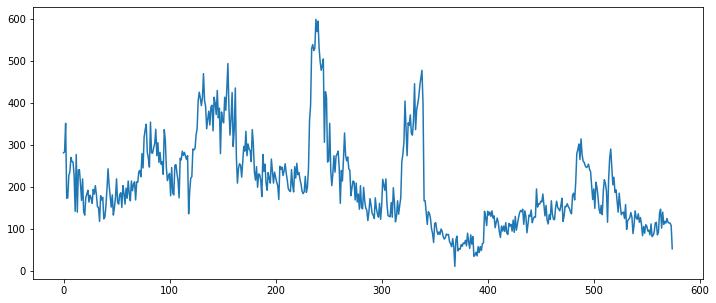

In [13]:
df['dateCreacion'].plot(figsize=(12,5))

# Check For Stationarity

In [14]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [15]:
adf_test(df['dateCreacion'])

1. ADF :  -3.1969282911583643
2. P-Value :  0.02016317169837937
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 572
5. Critical Values :
	 1% :  -3.441834071558759
	 5% :  -2.8666061267054626
	 10% :  -2.569468095872659


# Figure Out Order for ARIMA Model

In [16]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [17]:
stepwise_fit = auto_arima(df['dateCreacion'], trace=True,
                          suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5863.775, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5916.115, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5873.665, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5862.855, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5914.167, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5864.580, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5864.422, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5864.863, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5860.964, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5862.691, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5862.534, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5871.747, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5862.976, Time=0.17 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.745 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  575
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2928.482
Date:                Wed, 02 Jun 2021   AIC                           5860.964
Time:                        09:21:40   BIC                           5869.669
Sample:                             0   HQIC                          5864.359
                                - 575                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3266      0.028    -11.862      0.000      -0.381      -0.273
sigma2      1581.0827     51.116     30.931      0.000    1480.897    1681.268
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               604.63
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
from statsmodels.tsa.arima_model import ARIMA

# Split Data into Training and Testing

In [19]:
print(df.shape)

(575, 3)


In [20]:
i, m = df.shape

to_train = int(i*0.8)
to_test = i - to_train

print(to_train+to_test)

575


In [21]:
train=df.iloc[:to_train]
test=df.iloc[-to_test:]
print(train.shape,test.shape)
print(test.iloc[0]), print(test.iloc[-1])

(460, 3) (115, 3)
index                  460
Date            2020-10-30
dateCreacion           167
Name: 460, dtype: object
index                  574
Date            2021-04-21
dateCreacion            53
Name: 574, dtype: object


(None, None)

## Train the Model

In [22]:
from statsmodels.tsa.arima_model import ARIMA

In [23]:
model=ARIMA(train['dateCreacion'],order=(0,1,1))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.dateCreacion   No. Observations:                  459
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2369.727
Method:                       css-mle   S.D. of innovations             42.256
Date:                Wed, 02 Jun 2021   AIC                           4745.454
Time:                        09:21:40   BIC                           4757.841
Sample:                             1   HQIC                          4750.332
                                                                              
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.3450      1.324     -0.261      0.794      -2.939       2.249
ma.L1.D.dateCreacion    -0.3296      0.043     -7.611      0.000      -0.414      -0.245
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            3.0339           +0.0000j            3.0339            0.0000
-----------------------------------------------------------------------------
"""

# Make Predictions on Test Set

<AxesSubplot:>

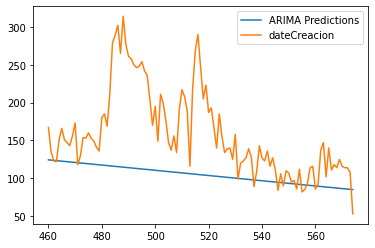

In [24]:
start = len(train)
end = len(train)+len(test)-1

pred = model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['dateCreacion'].plot(legend=True)

In [25]:
error = test
error['predicciones'] = pred
error.head()

,index,Date,dateCreacion,predicciones
460,460,2020-10-30,167,124.401642
461,461,2020-11-02,135,124.056670
462,462,2020-11-03,123,123.711697
463,463,2020-11-04,122,123.366724
464,464,2020-11-05,151,123.021752


In [26]:
error['diff'] = error.dateCreacion - error.predicciones
error.head()

,index,Date,dateCreacion,predicciones,diff
460,460,2020-10-30,167,124.401642,42.598358
461,461,2020-11-02,135,124.056670,10.943330
462,462,2020-11-03,123,123.711697,-0.711697
463,463,2020-11-04,122,123.366724,-1.366724
464,464,2020-11-05,151,123.021752,27.978248


In [27]:
error['diff'] = error['diff'].abs()

In [28]:
error.head()

,index,Date,dateCreacion,predicciones,diff
460,460,2020-10-30,167,124.401642,42.598358
461,461,2020-11-02,135,124.056670,10.943330
462,462,2020-11-03,123,123.711697,0.711697
463,463,2020-11-04,122,123.366724,1.366724
464,464,2020-11-05,151,123.021752,27.978248


In [29]:
error['diff'].describe()

count    115.000000
mean      55.364801
std       50.009525
min        0.711697
25%       21.969204
50%       34.703112
75%       82.986663
max      199.257592
Name: diff, dtype: float64

<AxesSubplot:>

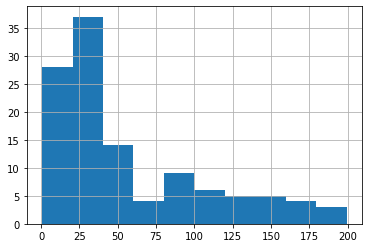

In [30]:
error['diff'].hist()

In [31]:
#pred.plot(legend='ARIMA Predictions')
#test['dateCreacion'].plot(legend=True)

In [32]:
test['dateCreacion'].mean()

158.58260869565217

In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['dateCreacion']))
print(rmse)


74.46117321677679


In [37]:
model2=ARIMA(df['dateCreacion'],order=(0,1,1))
model2=model2.fit()

# For Future Dates

In [38]:
pred=model2.predict(start=len(df),end=len(df)+50,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
#pred.index=index_future_dates
print(pred)

575    71.112787
576    70.744068
577    70.375348
578    70.006629
579    69.637909
580    69.269190
581    68.900470
582    68.531750
583    68.163031
584    67.794311
585    67.425592
586    67.056872
587    66.688153
588    66.319433
589    65.950713
590    65.581994
591    65.213274
592    64.844555
593    64.475835
594    64.107116
595    63.738396
596    63.369676
597    63.000957
598    62.632237
599    62.263518
600    61.894798
601    61.526078
602    61.157359
603    60.788639
604    60.419920
605    60.051200
606    59.682481
607    59.313761
608    58.945041
609    58.576322
610    58.207602
611    57.838883
612    57.470163
613    57.101444
614    56.732724
615    56.364004
616    55.995285
617    55.626565
618    55.257846
619    54.889126
620    54.520407
621    54.151687
622    53.782967
623    53.414248
624    53.045528
625    52.676809
Name: ARIMA Predictions, dtype: float64


<AxesSubplot:>

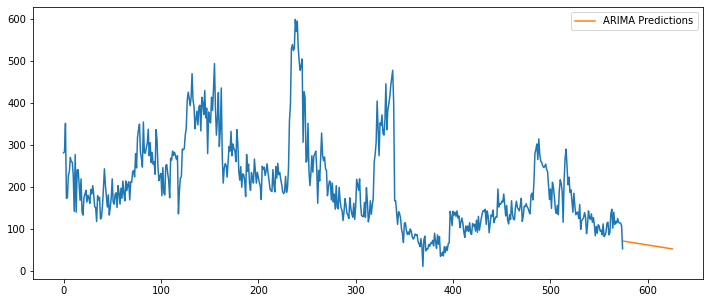

In [39]:
df['dateCreacion'].plot()
pred.plot(figsize=(12,5),legend=True)